<a href="https://colab.research.google.com/github/beedrumms/eta_/blob/main/plane_crashes_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting google colab on drive 
from google.colab import drive, files
import os
drive.mount("/content/drive")

import re 
import string
import pandas as pd 
import numpy as np

import plotly.express as px
from plotly.offline import plot
import plotly.graph_objects as go
import seaborn as sn
from plotly.subplots import make_subplots

import collections
from collections import Counter 
import itertools
from sklearn.feature_extraction.text import CountVectorizer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
d = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/plane_crashes_data_clean.csv')
df = d.iloc[:,1:]
df.head(3)

,date,month_year,time,month,days,years,location,proximity_flag,operator_1,operator_2,military_flg,primary_location,secondary_location,route,last_leg,training_flg,multi_route_flg,no_routes,ac_type,manufacturer,registration,summary,summary_ed,flight_no,total_aboard,passengers_aboard,crew_aboard,total_passed,passengers_passed,crew_passed,ground_passed
0,"September 17, 2008","September, 2008",17:18,September,17,2008,"fort myer , virginia",0,u.s. army,NaN,1,virginia,fort myer,demonstration,demonstration,0,0,1,wright flyer iii,wright,?,"During a demonstration flight, a U.S. Army fly...","During demonstration flight , U.S. Army flyer ...",?,2.0,1.0,1.0,1.0,1.0,0.0,0.0
1,"July 12, 2012","July, 2012",06:30,July,12,2012,"atlantic city , new jersey",0,u.s. navy,NaN,1,new jersey,atlantic city,test flight,test flight,0,0,1,dirigible,dirigible,?,First U.S. dirigible Akron exploded just offsh...,First U.S. dirigible Akron exploded offshore a...,?,5.0,0.0,5.0,5.0,0.0,5.0,0.0
2,"August 6, 2013","August, 2013",?,August,6,2013,"victoria , british columbia , canada",0,private,NaN,0,canada,british columbia,?,?,0,0,1,curtiss seaplane,curtiss,?,The first fatal airplane accident in Canada oc...,The first fatal airplane accident Canada occur...,?,1.0,0.0,1.0,1.0,0.0,1.0,0.0


#Basic Descriptive Data

In [3]:
df.describe()

,days,years,proximity_flag,military_flg,training_flg,multi_route_flg,no_routes,total_aboard,passengers_aboard,crew_aboard,total_passed,passengers_passed,crew_passed,ground_passed
count,5493.000000,5493.000000,5493.000000,5493.000000,5493.000000,5493.000000,5493.000000,5493.000000,5003.000000,5007.000000,5493.000000,4986.000000,4989.000000,5493.000000
mean,15.735664,1973.561442,0.329328,0.147278,0.017841,0.692336,1.779538,21.729110,17.955827,3.868384,16.335700,13.073406,3.195029,0.514655
std,8.792193,23.466316,0.470012,0.354415,0.132385,0.461569,0.635216,25.517395,24.645245,3.075695,20.318642,19.522408,2.860329,4.839260
min,1.000000,1922.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.000000,1955.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,2.000000,2.000000,3.000000,1.000000,1.000000,0.000000
50%,16.000000,1974.000000,0.000000,0.000000,0.000000,1.000000,2.000000,12.000000,9.000000,3.000000,9.000000,5.000000,2.000000,0.000000
75%,23.000000,1993.000000,1.000000,0.000000,0.000000,1.000000,2.000000,27.000000,23.000000,5.000000,21.000000,17.000000,4.000000,0.000000
max,31.000000,2021.000000,1.000000,1.000000,1.000000,1.000000,7.000000,155.000000,150.000000,61.000000,118.000000,112.000000,46.000000,125.000000


In [4]:
df.iloc[:,:15].value_counts()

date               month_year       time   month      days  years  location                  proximity_flag  operator_1             operator_2               military_flg  primary_location  secondary_location  route                                    last_leg   
April 12, 1973     April, 1973      14:50  April      12    1973   mett afb , california     1                 u.s. navy             nasa                    1              california       mett afb            ?                                        ?              1
May 10, 1946       May, 1946        ?      May        10    1946   munson , florida          0                u.s. navy                u.s. navy             1              florida          munson              ?                                        ?              1
May 1, 1967        May, 1967        16:20  May        1     1967   flushing , new york       0               greylock airways        private                 0              new york         flushing       

#Text Data Analytics

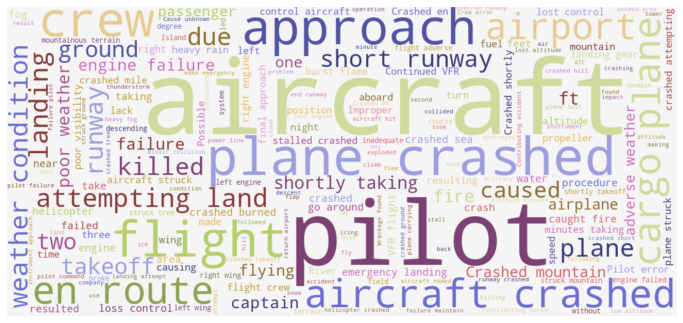

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
cloud_str = pd.Series(df['summary_ed']).str.cat(sep=' ')
cloud = WordCloud(width=1300, height=600, max_font_size=200, background_color="whitesmoke", colormap="tab20b").generate(cloud_str) # creating the word cloud 
plt.figure(figsize=(12,12))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
def get_top_1_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

sum1 = df['summary'].tolist()
common_words = get_top_1_trigram(sum1, 15)

summary1 = pd.DataFrame(common_words, columns = ['unigrams' , 'count'])

fig = go.Figure([go.Bar(x= summary1['unigrams'], y= summary1['count'])])
fig.update_layout(title=go.layout.Title(text="Top 15 Unigrams for Plane Crashes Summary Data"))
fig.show()

In [7]:
# going to make a function that creates top n-grams
def get_top_2_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# going to feed the location column into my function
sum2 = df['summary'].tolist()
common_words = get_top_2_trigram(sum2, 15)

summary2 = pd.DataFrame(common_words, columns = ['bigrams' , 'count'])

fig = go.Figure([go.Bar(x= summary2['bigrams'], y= summary2['count'])])
fig.update_layout(title=go.layout.Title(text="Top 15 trigrams for Plane Crashes Summary Data"))
fig.show()

In [8]:
def get_top_3_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

sum3 = df['summary'].tolist()
common_words3 = get_top_3_trigram(sum3, 15)

summary3 = pd.DataFrame(common_words3, columns = ['trigrams' , 'count'])

fig = go.Figure([go.Bar(x= summary3['trigrams'], y= summary3['count'])])
fig.update_layout(title=go.layout.Title(text="Top 15 Trigrams for Plane Crashes Summary Data"))
fig.show()

In [9]:
import sklearn 
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

sum_list = df['summary'].tolist()

tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english', ngram_range=(1, 3))  #vectoriser object
tf = tf_vectorizer.fit_transform(sum_list) # document-term matrix
alpha = .45     #Dirichlet prior of document-topic dist
beta = 0.05   #Dirichlet prior of topic-term dist

lda_model3 = LatentDirichletAllocation(n_components=3, doc_topic_prior=alpha, topic_word_prior=beta, learning_method='online', random_state=15, n_jobs=1).fit(tf) # pre-trained LDA model
lda_model4 = LatentDirichletAllocation(n_components=4, doc_topic_prior=alpha, topic_word_prior=beta, learning_method='online', random_state=15, n_jobs=1).fit(tf) # pre-trained LDA model
lda_model5 = LatentDirichletAllocation(n_components=5, doc_topic_prior=alpha, topic_word_prior=beta, learning_method='online', random_state=15, n_jobs=1).fit(tf) # pre-trained LDA model
lda_model6 = LatentDirichletAllocation(n_components=6, doc_topic_prior=alpha, topic_word_prior=beta, learning_method='online', random_state=15, n_jobs=1).fit(tf) # pre-trained LDA model

In [10]:
print('Model Perplexity - 3 Topics:',lda_model3.perplexity(tf, sub_sampling = False))
print('Model Log-Likelihood - 3 Topics:', lda_model3.score(tf))

print('Model Perplexity - 4 Topics:',lda_model4.perplexity(tf, sub_sampling = False))
print('Model Log-Likelihood - 4 Topics:', lda_model4.score(tf))

print('Model Perplexity - 5 Topics:',lda_model5.perplexity(tf, sub_sampling = False))
print('Model Log-Likelihood - 5 Topics:', lda_model5.score(tf))

print('Model Perplexity - 6 Topics:',lda_model6.perplexity(tf, sub_sampling = False))
print('Model Log-Likelihood - 6 Topics:', lda_model6.score(tf))

# we want the lowest perplexity and highest log-likelihood compared to the other k values

Model Perplexity - 3 Topics: 4973.615541875083
Model Log-Likelihood - 3 Topics: -1349187.590374166
Model Perplexity - 4 Topics: 4813.037628905238
Model Log-Likelihood - 4 Topics: -1343985.6389635147
Model Perplexity - 5 Topics: 4799.4464442926965
Model Log-Likelihood - 5 Topics: -1343537.4123183803
Model Perplexity - 6 Topics: 4850.950399061943
Model Log-Likelihood - 6 Topics: -1345229.314423165


In [11]:
#pip install pyldavis   # this bipasses some compatibility issues 
#!pip install pandas==1.3.1
#!pip install pandas --upgrade

# Creating LDA plot of best topic # 
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.enable_notebook()
display_data = pyLDAvis.sklearn.prepare(lda_model3, tf, tf_vectorizer)                 
pyLDAvis.display(display_data)   

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/past/builtins/misc.py:4: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



In [12]:
# Getting predicted topic for each tweet 
topics = lda_model3.transform(tf)

Topic_Assigned = [] 
for t in range(topics.shape[0]):
  predicted_topic = topics[t].argmax()
  Topic_Assigned.append(predicted_topic)
  predicted_topic = None

print(Topic_Assigned[:10])

df['topic'] = Topic_Assigned
df[:3]

[2, 0, 1, 1, 2, 0, 2, 1, 0, 2]


,date,month_year,time,month,days,years,location,proximity_flag,operator_1,operator_2,military_flg,primary_location,secondary_location,route,last_leg,training_flg,multi_route_flg,no_routes,ac_type,manufacturer,registration,summary,summary_ed,flight_no,total_aboard,passengers_aboard,crew_aboard,total_passed,passengers_passed,crew_passed,ground_passed,topic
0,"September 17, 2008","September, 2008",17:18,September,17,2008,"fort myer , virginia",0,u.s. army,NaN,1,virginia,fort myer,demonstration,demonstration,0,0,1,wright flyer iii,wright,?,"During a demonstration flight, a U.S. Army fly...","During demonstration flight , U.S. Army flyer ...",?,2.0,1.0,1.0,1.0,1.0,0.0,0.0,2
1,"July 12, 2012","July, 2012",06:30,July,12,2012,"atlantic city , new jersey",0,u.s. navy,NaN,1,new jersey,atlantic city,test flight,test flight,0,0,1,dirigible,dirigible,?,First U.S. dirigible Akron exploded just offsh...,First U.S. dirigible Akron exploded offshore a...,?,5.0,0.0,5.0,5.0,0.0,5.0,0.0,0
2,"August 6, 2013","August, 2013",?,August,6,2013,"victoria , british columbia , canada",0,private,NaN,0,canada,british columbia,?,?,0,0,1,curtiss seaplane,curtiss,?,The first fatal airplane accident in Canada oc...,The first fatal airplane accident Canada occur...,?,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1


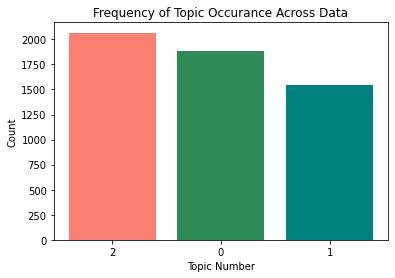

In [13]:
df['topic'] = [str(i) for i in df['topic']]
num_topics = df['topic'].unique()
topic_counts = df['topic'].value_counts()

plt.bar(x = num_topics, height = topic_counts, color = ['salmon', 'seagreen', 'teal', 'maroon'])
plt.xlabel("Topic Number")
plt.ylabel("Count")
plt.title("Frequency of Topic Occurance Across Data")
plt.rc('figure', figsize=(15,9))
plt.show()

#Variation within variables

In [14]:
df_quant = df.iloc[:, 24:]

In [20]:
fig1 = px.histogram(df, x="total_aboard", histnorm='probability density')
fig1.show()

fig2 = px.histogram(df, x="passengers_aboard", histnorm='probability density')
fig2.show()

fig3 = px.histogram(df, x="crew_aboard", histnorm='probability density')
fig3.show()

fig4 = px.histogram(df, x="total_passed", histnorm='probability density')
fig4.show()

fig5 = px.histogram(df, x="passengers_passed", histnorm='probability density')
fig5.show()

fig5 = px.histogram(df, x="crew_passed", histnorm='probability density')
fig5.show()

fig7 = px.histogram(df, x="ground_passed", histnorm='probability density')
fig7.show()

#Covariation between variables

In [16]:
import plotly.express as px

fig = px.scatter_matrix(df, dimensions=['total_aboard','passengers_aboard','crew_aboard', 'total_passed','passengers_passed','crew_passed','ground_passed'])
fig.show()

In [17]:
corrMatrix = df_quant.corr()
print (corrMatrix)

                   total_aboard  passengers_aboard  ...  crew_passed  ground_passed
total_aboard           1.000000           0.994218  ...     0.282077       0.003800
passengers_aboard      0.994218           1.000000  ...     0.198941       0.003226
crew_aboard            0.506841           0.413057  ...     0.823810       0.031190
total_passed           0.759700           0.755565  ...     0.505869       0.007672
passengers_passed      0.773287           0.776287  ...     0.395093       0.006139
crew_passed            0.282077           0.198941  ...     1.000000       0.030558
ground_passed          0.003800           0.003226  ...     0.030558       1.000000

[7 rows x 7 columns]


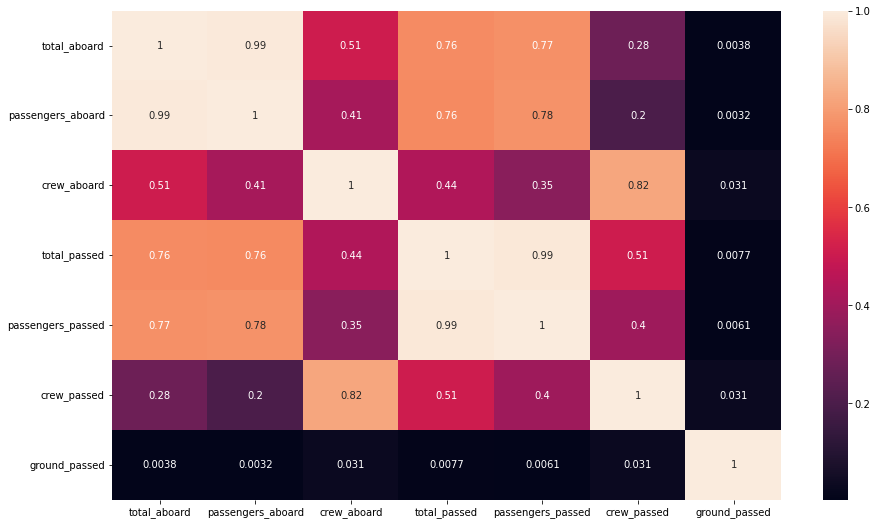

In [18]:
sn.heatmap(corrMatrix, annot=True)
plt.show()